## Data Cleaning & Preparation

In [1]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from langdetect import detect

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 100

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"\n\nFound {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"\nProcessing file: {file_path} with {reviews.shape[0]} rows")
                
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                all_reviews.append(reviews)

    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # y_ground_truth = combined_reviews['Review Score']
    # y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    # The scores are already normalized by MinMaxScaler, so use them directly
    y_normalized = combined_reviews['Review Score'].values

    print(f"Distribution of normalized scores for {hotel_name}: {np.histogram(y_normalized, bins=10)}")

    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    print(f"y_labels distribution for {hotel_name}: {np.unique(y_labels, return_counts=True)}")

    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y_labels, test_size=0.3, random_state=42)

    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, 
                        x_train=x_train, 
                        x_test=x_test, 
                        y_train=y_train, 
                        y_test=y_test, 
                        y_labels=y_labels,  
                        x_test_indices=np.arange(len(x_test)))

    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_labels shape: {y_labels.shape}")

# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        print(f"Processing {hotel_name} reviews...")
        process_reviews(hotel_name, source_folders, output_folder)
        print(f"Finished processing {hotel_name} reviews.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing bai_hotel reviews...


Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel

Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 1763 rows
After removing duplicates: 1748 rows
After text preprocessing: 1748 rows


Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel

Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 661 rows
After removing duplicates: 656 rows
After text preprocessing: 656 rows


Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel

Processing file: ..\raw data\klook_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 114 rows
After dropping missing values: 114 rows
After normalizing ratings: 114 rows
After filteri

# NOTES:
- `y_labels` represent the sentiment labels for all the reviews in the dataset, before splitting into training and testing sets. These labels are useful for tasks like augmentation, where you might want to selectively augment only negative reviews or analyze the distribution of sentiments across your entire dataset.
- `y_train` and `y_test` represent the labels for the training and testing datasets, respectively. These labels are used during the model training and evaluation process.

- `y_labels` is essential for understanding the sentiment distribution across your entire dataset, enabling you to make decisions about data augmentation or rebalancing.
- `y_train` and `y_test` are critical for the actual machine learning process, where the data is split into subsets for training the model and evaluating its performance.

## EDA

In [2]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the base path for datasets
# base_output_path = os.path.join('..', 'datasets')

# # List of hotel folders and their corresponding names for the EDA plots
# hotel_folders = {
#     '1_bai_hotel': 'bai_hotel',
#     '2_dusit_thani_mactan': 'dusit_thani_mactan',
#     '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
#     '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
#     '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
#     '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
# }

# for folder, hotel_name in hotel_folders.items():
#     output_folder = os.path.join(base_output_path, folder)
    
#     # Load the preprocessed data
#     data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
#     data = np.load(data_path)
    
#     x_train = data['x_train']
#     x_test = data['x_test']
#     y_train = data['y_train']
#     y_test = data['y_test']
    
#     # For EDA purposes only
#     # Review lengths
#     review_lengths = [len(review) for review in x_train]
#     plt.hist(review_lengths, bins=50)
#     plt.title(f'{hotel_name} Review Lengths')
#     plt.xlabel('Review Length (in words)')
#     plt.ylabel('Frequency')
#     plt.show()
    
#     # Distribution of Ratings in Training Data
#     plt.hist(y_train, bins=10, edgecolor='k')
#     plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
#     plt.xlabel("Rating")
#     plt.ylabel("Frequency")
#     plt.show()
    
#     # Distribution of Sentiment Scores
#     plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
#     plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
#     plt.legend(loc='upper right')
#     plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
#     plt.xlabel('Sentiment Score')
#     plt.ylabel('Frequency')
#     plt.show()

# Checking of OG negative counts (`y_train`)

In [3]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and check sentiment labels in y_train
def check_sentiment_labels(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"  # Adjust path as needed
        data = np.load(data_path)

        y_train = data['y_train']  # Load sentiment labels from y_train

        # Check unique values and count of negative labels
        print(f"Hotel: {hotel_name}")
        print(f"y_train unique values: {np.unique(y_train)}")
        print(f"Number of negative labels (should be -1): {np.sum(y_train == -1)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Check sentiment labels in y_train for each hotel
for hotel in hotels:
    check_sentiment_labels(hotel)


Hotel: bai_hotel
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 51
--------------------------------------------------
Hotel: dusit_thani_mactan
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 82
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 6
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 21
--------------------------------------------------
Hotel: seda_ayala_center_cebu
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 37
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 52
--------------------------------------------------


## Positive & Negative Counts (`y_labels`)
#### to test for overfitting or underfitting check

In [4]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels
def count_sentiments(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)

        y_labels = data['y_labels']  # Assuming y_labels contains sentiment labels

        positive_count = np.sum(y_labels == 1)
        negative_count = np.sum(y_labels == -1)
        neutral_count = np.sum(y_labels == 0)

        print(f"Hotel: {hotel_name}")
        print(f"Positive reviews: {positive_count}")
        print(f"Negative reviews: {negative_count}")
        print(f"Neutral reviews: {neutral_count}")
        print(f"Total reviews: {len(y_labels)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Count and display sentiments for each hotel
for hotel in hotels:
    count_sentiments(hotel)

Hotel: bai_hotel
Positive reviews: 3473
Negative reviews: 82
Neutral reviews: 294
Total reviews: 3849
--------------------------------------------------
Hotel: dusit_thani_mactan
Positive reviews: 1395
Negative reviews: 118
Neutral reviews: 319
Total reviews: 1832
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
Positive reviews: 49
Negative reviews: 7
Neutral reviews: 7
Total reviews: 63
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
Positive reviews: 403
Negative reviews: 29
Neutral reviews: 91
Total reviews: 523
--------------------------------------------------
Hotel: seda_ayala_center_cebu
Positive reviews: 1563
Negative reviews: 53
Neutral reviews: 267
Total reviews: 1883
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
Positive reviews: 1064
Negative reviews: 91
Neutral reviews: 420
Total reviews: 1575
--------------------------------------------------


# --- CLASS IMBALANCE ---  
### - Solution:
####    Augment data (negatives only)

# Data Augmentation for Negative Reviews (PRE-SPLIT)

In [5]:
import os
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
AUGMENTATION_FACTOR = 5

# Augmentation function
def augment_review(review, num_augments=5):
    words = word_tokenize(review)
    augmented_reviews = []
    for _ in range(num_augments):
        new_review = []
        for word in words:
            if word in stopwords.words('english'):
                new_review.append(word)
            else:
                synonyms = wordnet.synsets(word)
                if synonyms:
                    synonym = synonyms[0].lemmas()[0].name()
                    new_review.append(synonym)
                else:
                    new_review.append(word)
        augmented_reviews.append(' '.join(new_review))
    return augmented_reviews

# Augment and save data
def augment_and_save_data(hotel_name, original_folder_path, augmented_folder_path):
    # Load the original data
    data_path = os.path.join(original_folder_path, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    x_train = data['x_train']
    y_train = data['y_train']  # Use y_train to identify sentiment for augmentation
    x_test = data['x_test']    # Load test data but will remain untouched during augmentation
    y_test = data['y_test']

    # Ensure the output directory exists
    os.makedirs(augmented_folder_path, exist_ok=True)

    # Debug: Show the distribution of y_train
    print(f"Unique values in y_train for {hotel_name}: {np.unique(y_train)}")

    # Identify negative reviews
    negative_indices = np.nonzero(y_train == -1)[0]
    print(f"Total original negative reviews found: {len(negative_indices)}")

    if len(negative_indices) == 0:
        print(f"No negative reviews to augment for {hotel_name}. Skipping augmentation.")
        return

    # Augment negative reviews
    augmented_reviews = []
    augmented_labels = []

    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts([" ".join(map(str, seq)) for seq in x_train])

    # Ensure that indices are within bounds
    negative_indices = [index for index in negative_indices if index < len(x_train)]

    if len(negative_indices) == 0:
        print(f"No valid negative review indices to augment for {hotel_name}.")
        return

    for index in negative_indices:
        original_sequence = x_train[index]
        original_review = " ".join([tokenizer.index_word.get(i, "[UNK]") for i in original_sequence if i != 0])
        new_reviews = augment_review(original_review, AUGMENTATION_FACTOR)

        augmented_reviews.extend(new_reviews)
        augmented_labels.extend([-1] * len(new_reviews))

    # Convert augmented reviews to sequences and pad them
    augmented_sequences = tokenizer.texts_to_sequences(augmented_reviews)
    augmented_sequences_padded = pad_sequences(augmented_sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Combine augmented data with the original training data
    x_train_augmented = np.concatenate([x_train, augmented_sequences_padded], axis=0)
    y_train_augmented = np.concatenate([y_train, np.array(augmented_labels)], axis=0)

    # Debug: Check lengths after concatenation
    print(f"x_train_augmented shape: {x_train_augmented.shape}")
    print(f"y_train_augmented shape: {y_train_augmented.shape}")

    if len(x_train_augmented) != len(y_train_augmented):
        raise ValueError(f"Inconsistent lengths after augmentation: {len(x_train_augmented)} samples in x_train, {len(y_train_augmented)} labels in y_train.")

    # Save both the augmented training data and the original test data
    output_path = os.path.join(augmented_folder_path, f"{hotel_name}_augmented_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train_augmented, y_train=y_train_augmented, x_test=x_test, y_test=y_test)

    print(f"Saved augmented data for {hotel_name} with {x_train_augmented.shape[0]} training reviews.")

# Define source and output folders using relative paths
def main():
    hotel_folder_mapping = {
        'bai_hotel': '1_bai_hotel',
        'dusit_thani_mactan': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
    }
    
    base_folder_path = '../datasets'
    augmented_base_folder_path = '../augmented_datasets'

    for hotel in hotel_folder_mapping:
        print(f"Processing {hotel}...")
        original_folder_path = os.path.join(base_folder_path, hotel_folder_mapping[hotel])
        augmented_folder_path = os.path.join(augmented_base_folder_path, hotel_folder_mapping[hotel])
        augment_and_save_data(hotel, original_folder_path, augmented_folder_path)

if __name__ == "__main__":
    main()


Processing bai_hotel...
Unique values in y_train for bai_hotel: [-1.  0.  1.]
Total original negative reviews found: 51


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


x_train_augmented shape: (2949, 200)
y_train_augmented shape: (2949,)
Saved augmented data for bai_hotel with 2949 training reviews.
Processing dusit_thani_mactan...
Unique values in y_train for dusit_thani_mactan: [-1.  0.  1.]
Total original negative reviews found: 82
x_train_augmented shape: (1692, 200)
y_train_augmented shape: (1692,)
Saved augmented data for dusit_thani_mactan with 1692 training reviews.
Processing fairfield_by_marriott_cebu...
Unique values in y_train for fairfield_by_marriott_cebu: [-1.  0.  1.]
Total original negative reviews found: 6
x_train_augmented shape: (74, 200)
y_train_augmented shape: (74,)
Saved augmented data for fairfield_by_marriott_cebu with 74 training reviews.
Processing jpark_island_resort_and_waterpark...
Unique values in y_train for jpark_island_resort_and_waterpark: [-1.  0.  1.]
Total original negative reviews found: 21
x_train_augmented shape: (471, 200)
y_train_augmented shape: (471,)
Saved augmented data for jpark_island_resort_and_water

## Checking the new `y_train` count

In [6]:
# Function to load and check sentiment labels in y_train
def check_sentiment_labels(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"  # Adjust path as needed
        data = np.load(data_path)

        y_train = data['y_train']  # Load sentiment labels from y_train

        # Check unique values and count of negative labels
        print(f"Hotel: {hotel_name}")
        print(f"y_train unique values: {np.unique(y_train)}")
        print(f"Number of negative labels (should be -1): {np.sum(y_train == -1)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Check sentiment labels in y_train for each hotel
for hotel in hotels:
    check_sentiment_labels(hotel)


Hotel: bai_hotel
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 306
--------------------------------------------------
Hotel: dusit_thani_mactan
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 492
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 36
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 126
--------------------------------------------------
Hotel: seda_ayala_center_cebu
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 222
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
y_train unique values: [-1.  0.  1.]
Number of negative labels (should be -1): 312
--------------------------------------------------


# Comparison of reviews OG VS Augmented

In [7]:
import numpy as np
import pandas as pd

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels in y_train
def count_sentiments(hotel_name, folder_type='original'):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        if folder_type == 'original':
            data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        elif folder_type == 'augmented':
            data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"
        else:
            raise ValueError("Invalid folder_type. Choose 'original' or 'augmented'.")

        data = np.load(data_path)
        y_train = data['y_train']  # Load sentiment labels from y_train

        positive_count = np.sum(y_train == 1)
        negative_count = np.sum(y_train == -1)
        neutral_count = np.sum(y_train == 0)
        total_reviews = len(y_train)

        return positive_count, negative_count, neutral_count, total_reviews

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None, None, None, None

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Prepare a DataFrame to store the results
columns = ['Hotel', 'Positive (Original)', 'Negative (Original)', 'Neutral (Original)', 'Total (Original)',
           'Positive (Augmented)', 'Negative (Augmented)', 'Neutral (Augmented)', 'Total (Augmented)']
results_df = pd.DataFrame(columns=columns)

# Count and store sentiments for each hotel
for hotel in hotels:
    original_counts = count_sentiments(hotel, folder_type='original')
    augmented_counts = count_sentiments(hotel, folder_type='augmented')

    if original_counts[0] is not None and augmented_counts[0] is not None:
        # Create a DataFrame for the current hotel's counts
        hotel_df = pd.DataFrame({
            'Hotel': [hotel],
            'Positive (Original)': [original_counts[0]],
            'Negative (Original)': [original_counts[1]],
            'Neutral (Original)': [original_counts[2]],
            'Total (Original)': [original_counts[3]],
            'Positive (Augmented)': [augmented_counts[0]],
            'Negative (Augmented)': [augmented_counts[1]],
            'Neutral (Augmented)': [augmented_counts[2]],
            'Total (Augmented)': [augmented_counts[3]],
        })
        # Concatenate the hotel_df to results_df
        results_df = pd.concat([results_df, hotel_df], ignore_index=True)

results_df


,Hotel,Positive (Original),Negative (Original),Neutral (Original),Total (Original),Positive (Augmented),Negative (Augmented),Neutral (Augmented),Total (Augmented)
0,bai_hotel,2442,51,201,2694,2442,306,201,2949
1,dusit_thani_mactan,969,82,231,1282,969,492,231,1692
2,fairfield_by_marriott_cebu,34,6,4,44,34,36,4,74
3,jpark_island_resort_and_waterpark,284,21,61,366,284,126,61,471
4,seda_ayala_center_cebu,1095,37,186,1318,1095,222,186,1503
5,waterfront_hotel_and_casino,754,52,296,1102,754,312,296,1362


# General Sentiment Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(





Training the CNN-biLSTM model for Hotel bai_hotel...
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8638 - loss: 0.2831 - val_accuracy: 0.1254 - val_loss: 1.7921
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9103 - loss: 0.0284 - val_accuracy: 0.1186 - val_loss: -93.2468
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9045 - loss: -2.6041 - val_accuracy: 0.1153 - val_loss: -340.4522
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9247 - loss: -8.3222 - val_accuracy: 0.1186 - val_loss: -657.4257
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9273 - loss: -14.3123 - val_accuracy: 0.1186 - val_loss: -1057.0076
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9331 - loss: -26.5377 - val_accuracy: 0.1186 - val_loss: -1474.0764
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9379 - loss: -38.5070 - val_accuracy: 0.1186 - val_loss: -1831.0352
Epoch 8/100
83/83 ━━

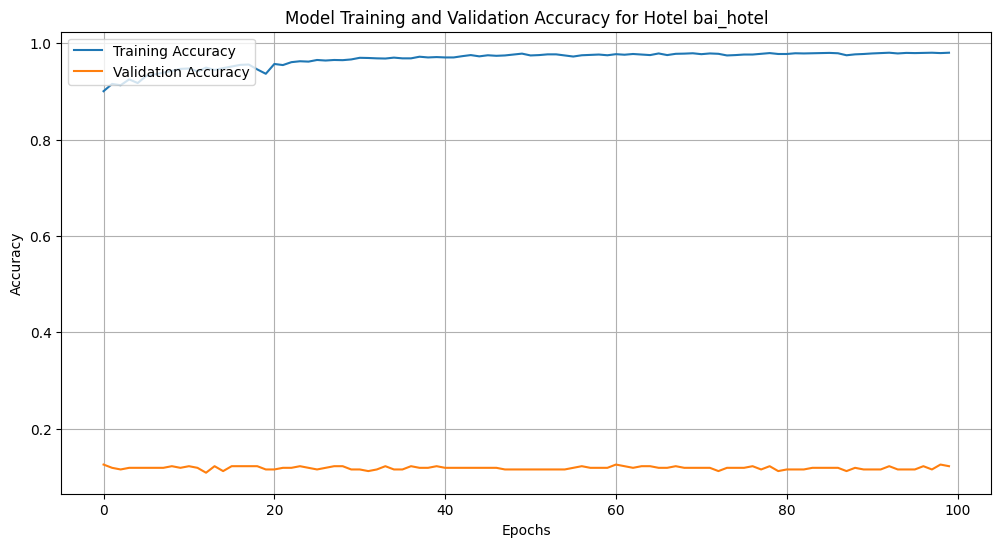

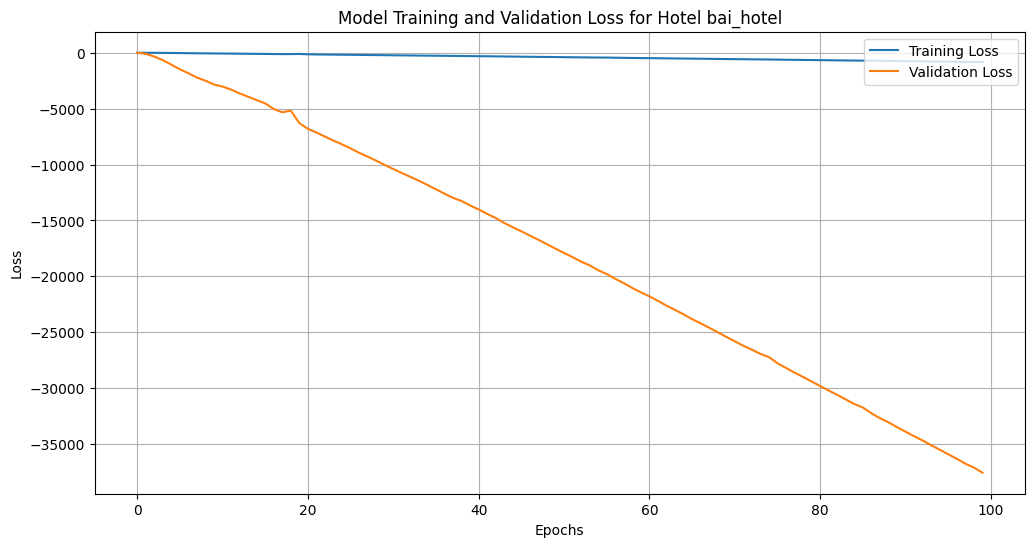

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8754 - loss: 814.8613
Test Loss for Hotel bai_hotel: 717.4483642578125
Test Accuracy for Hotel bai_hotel: 0.8753246665000916
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Classification Report for Hotel bai_hotel:
              precision    recall  f1-score   support

    Negative       0.44      0.29      0.35       124
    Positive       0.92      0.96      0.94      1031

    accuracy                           0.88      1155
   macro avg       0.68      0.62      0.64      1155
weighted avg       0.87      0.88      0.87      1155



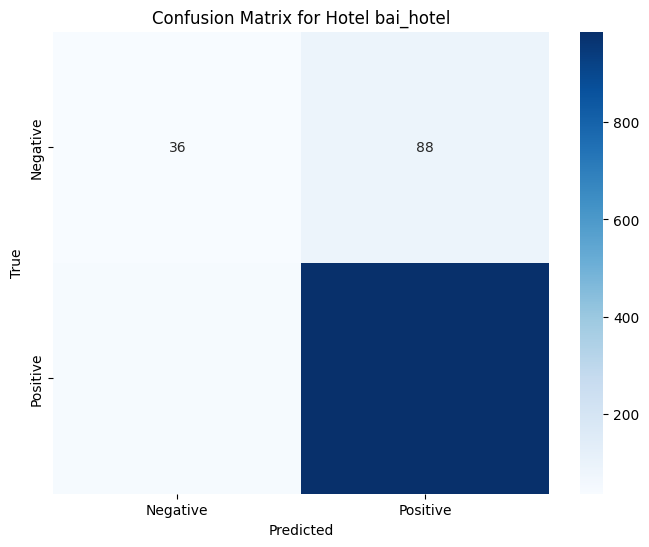

Mean Squared Error for Hotel bai_hotel: 0.1766233887386252
Predicted sentiment values for Hotel bai_hotel saved in ../predictions/1_bai_hotel



Training the CNN-biLSTM model for Hotel dusit_thani_mactan...
Epoch 1/100


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.2483 - loss: 0.1589 - val_accuracy: 0.0000e+00 - val_loss: -77.2823
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6273 - loss: -25.1530 - val_accuracy: 0.0000e+00 - val_loss: -498.5302
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5863 - loss: -112.9805 - val_accuracy: 0.0000e+00 - val_loss: -1108.9785
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6472 - loss: -209.6971 - val_accuracy: 0.0000e+00 - val_loss: -1651.2125
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6542 - loss: -316.5588 - val_accuracy: 0.0000e+00 - val_loss: -2115.5979
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6845 - loss: -461.6430 - val_accuracy: 0.0000e+00 - val_loss: -2699.9895
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6253 - loss: -559.8016 - val_accuracy: 0.0000e+00 - val_loss: -3292.8887
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms

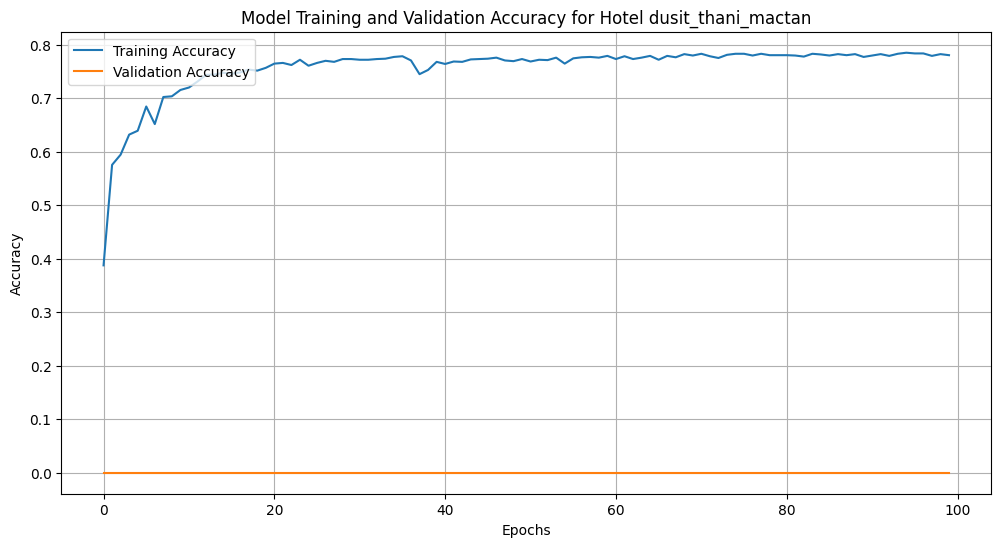

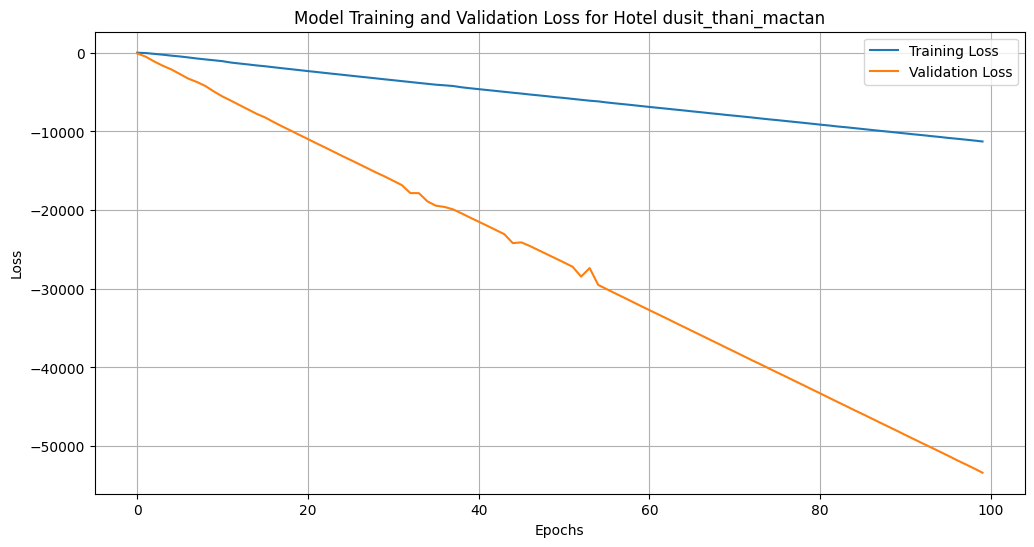

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7662 - loss: 1553.9635
Test Loss for Hotel dusit_thani_mactan: 1200.5894775390625
Test Accuracy for Hotel dusit_thani_mactan: 0.7545454502105713
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Classification Report for Hotel dusit_thani_mactan:
              precision    recall  f1-score   support

    Negative       0.57      0.62      0.59       124
    Positive       0.89      0.86      0.88       426

    accuracy                           0.81       550
   macro avg       0.73      0.74      0.73       550
weighted avg       0.82      0.81      0.81       550



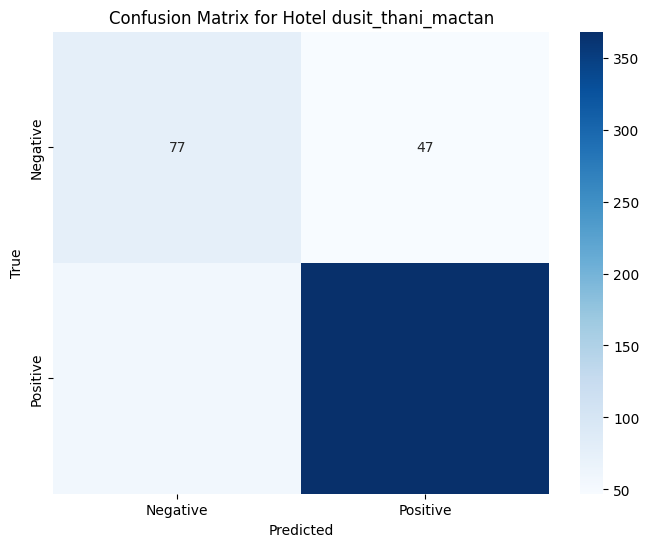

Mean Squared Error for Hotel dusit_thani_mactan: 0.2781561594696125
Predicted sentiment values for Hotel dusit_thani_mactan saved in ../predictions/2_dusit_thani_mactan



Training the CNN-biLSTM model for Hotel fairfield_by_marriott_cebu...
Epoch 1/100


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - accuracy: 0.2738 - loss: 0.6703 - val_accuracy: 0.0000e+00 - val_loss: -1.2583
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0616 - loss: 0.3660 - val_accuracy: 0.0000e+00 - val_loss: -4.7998
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0616 - loss: 0.5722 - val_accuracy: 0.0000e+00 - val_loss: -7.3596
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0498 - loss: 0.8001 - val_accuracy: 0.0000e+00 - val_loss: -12.9947
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0576 - loss: 0.7132 - val_accuracy: 0.0000e+00 - val_loss: -20.7816
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0616 - loss: 1.7038 - val_accuracy: 0.0000e+00 - val_loss: -23.8377
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.0772 - loss: 1.1223 - val_accuracy: 0.0000e+00 - val_loss: -18.6421
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0537 - loss: 0.5394 - val_

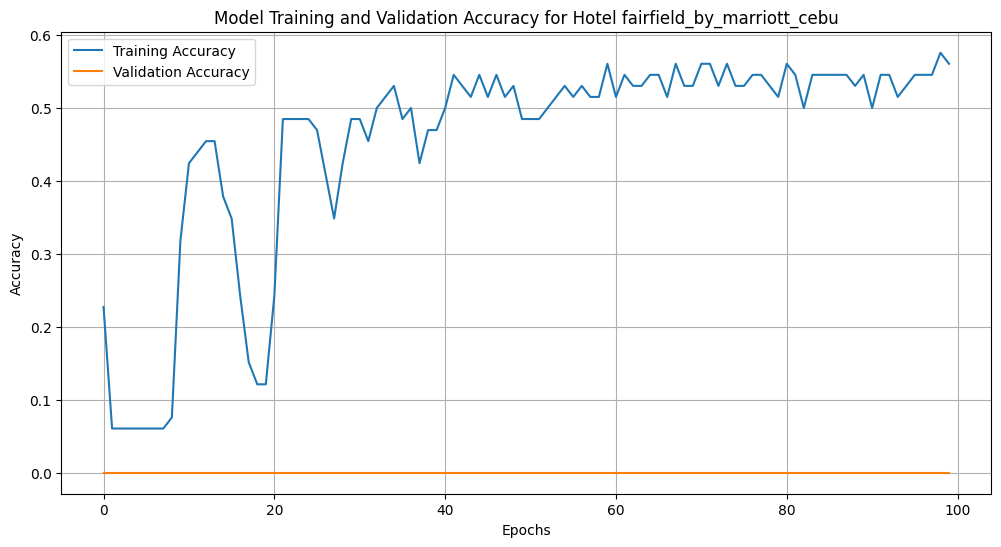

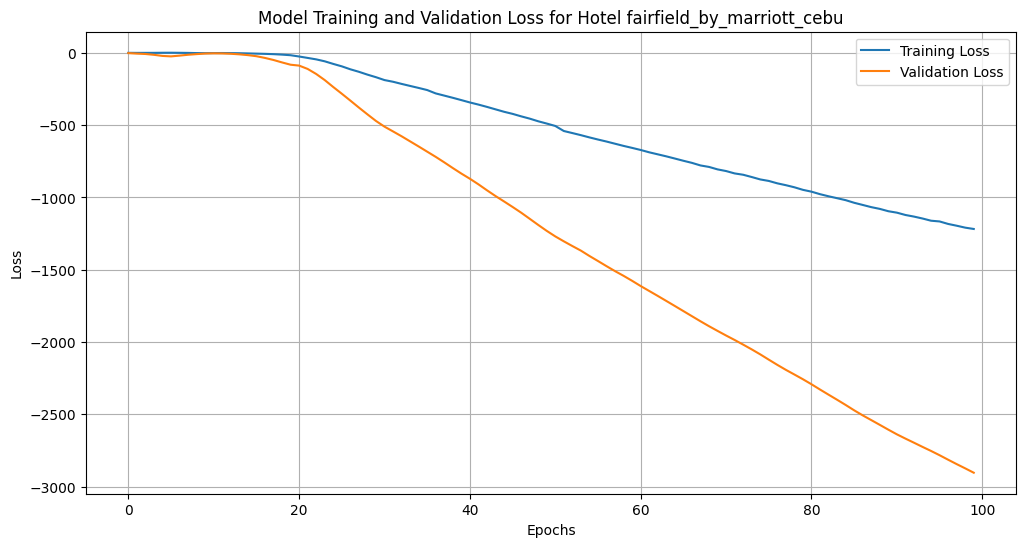

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4737 - loss: 338.1686
Test Loss for Hotel fairfield_by_marriott_cebu: 338.1686096191406
Test Accuracy for Hotel fairfield_by_marriott_cebu: 0.4736842215061188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

Classification Report for Hotel fairfield_by_marriott_cebu:
              precision    recall  f1-score   support

    Negative       0.12      0.25      0.17         4
    Positive       0.73      0.53      0.62        15

    accuracy                           0.47        19
   macro avg       0.43      0.39      0.39        19
weighted avg       0.60      0.47      0.52        19



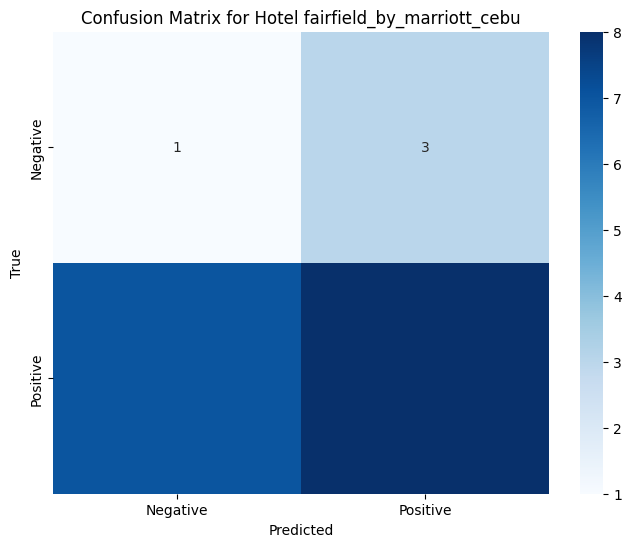

Mean Squared Error for Hotel fairfield_by_marriott_cebu: 0.6694090291224672
Predicted sentiment values for Hotel fairfield_by_marriott_cebu saved in ../predictions/3_fairfield_by_marriott_cebu



Training the CNN-biLSTM model for Hotel jpark_island_resort_and_waterpark...
Epoch 1/100


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3129 - loss: 0.5579 - val_accuracy: 0.0000e+00 - val_loss: 0.1051
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5594 - loss: -0.0272 - val_accuracy: 0.0000e+00 - val_loss: -17.8790
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5657 - loss: -6.0552 - val_accuracy: 0.0000e+00 - val_loss: -94.8590
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6190 - loss: -12.8329 - val_accuracy: 0.0000e+00 - val_loss: -206.3052
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7498 - loss: -42.8251 - val_accuracy: 0.0000e+00 - val_loss: -296.7862
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7436 - loss: -62.2533 - val_accuracy: 0.0000e+00 - val_loss: -499.3457
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6602 - loss: -107.5199 - val_accuracy: 0.0000e+00 - val_loss: -665.8744
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accurac

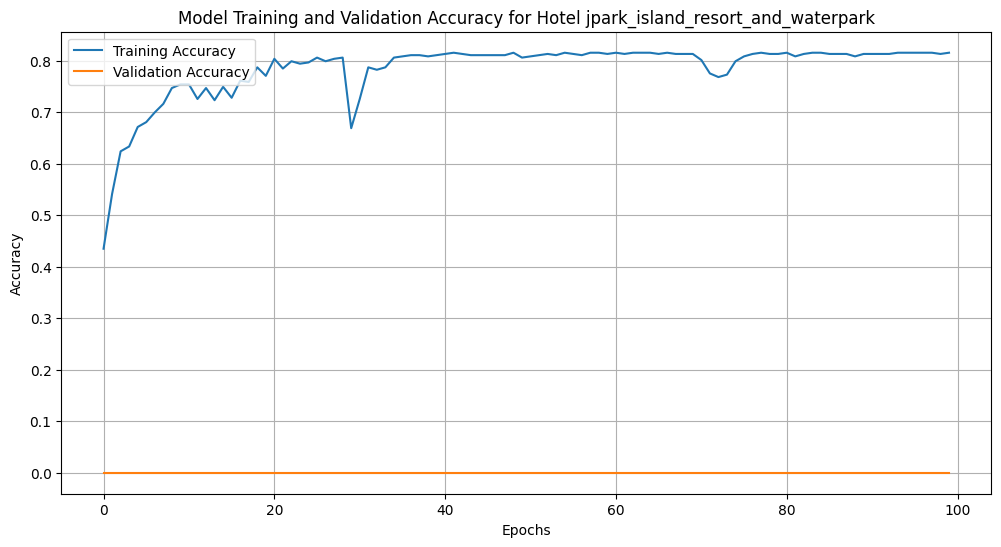

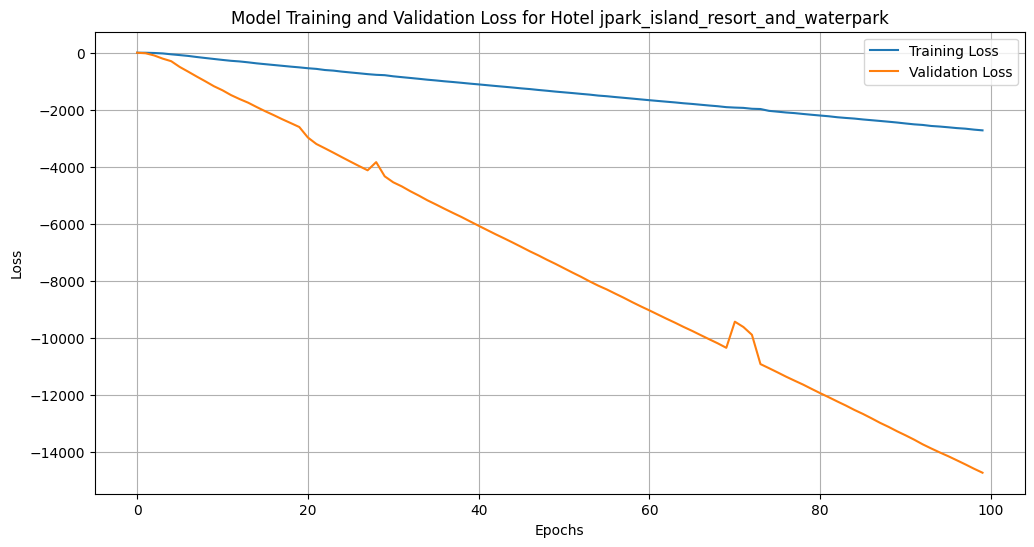

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7120 - loss: 963.5045
Test Loss for Hotel jpark_island_resort_and_waterpark: 1252.25830078125
Test Accuracy for Hotel jpark_island_resort_and_waterpark: 0.6815286874771118
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step WARNING:tensorflow:5 out of the last 24 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000171970EFCE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━

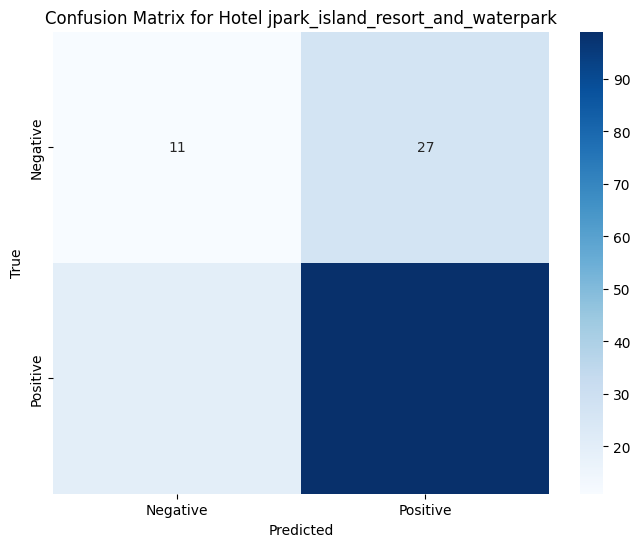

Mean Squared Error for Hotel jpark_island_resort_and_waterpark: 0.4140123097962306
Predicted sentiment values for Hotel jpark_island_resort_and_waterpark saved in ../predictions/4_jpark_island_resort_and_waterpark



Training the CNN-biLSTM model for Hotel seda_ayala_center_cebu...
Epoch 1/100


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7495 - loss: 0.4461 - val_accuracy: 0.0000e+00 - val_loss: 3.0035
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8159 - loss: 0.0742 - val_accuracy: 0.0000e+00 - val_loss: -32.5210
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8333 - loss: -4.1730 - val_accuracy: 0.0000e+00 - val_loss: -140.9357
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8156 - loss: -15.6567 - val_accuracy: 0.0000e+00 - val_loss: -448.0820
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8228 - loss: -36.2084 - val_accuracy: 0.0000e+00 - val_loss: -742.6043
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8538 - loss: -60.6694 - val_accuracy: 0.0000e+00 - val_loss: -1049.3163
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8596 - loss: -70.2357 - val_accuracy: 0.0000e+00 - val_loss: -1327.8164
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accura

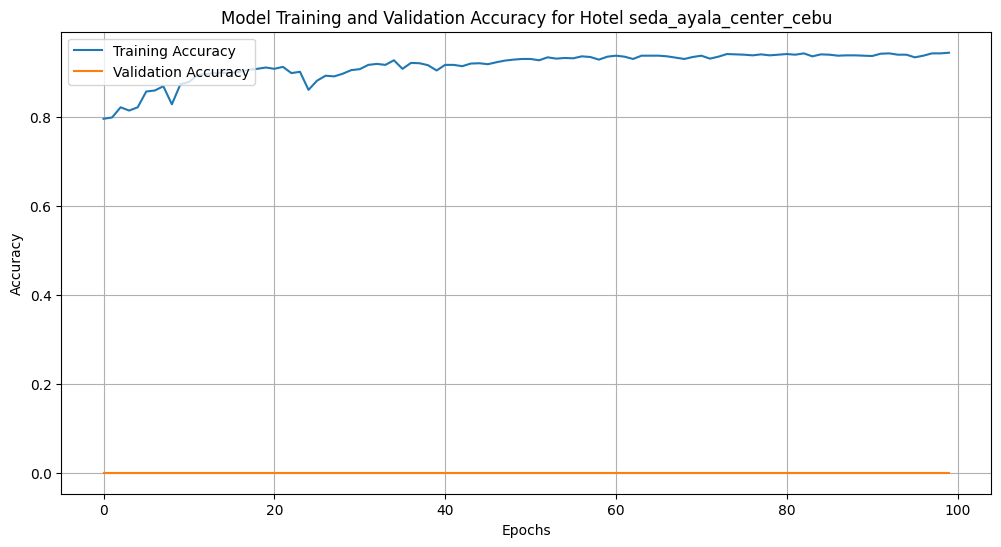

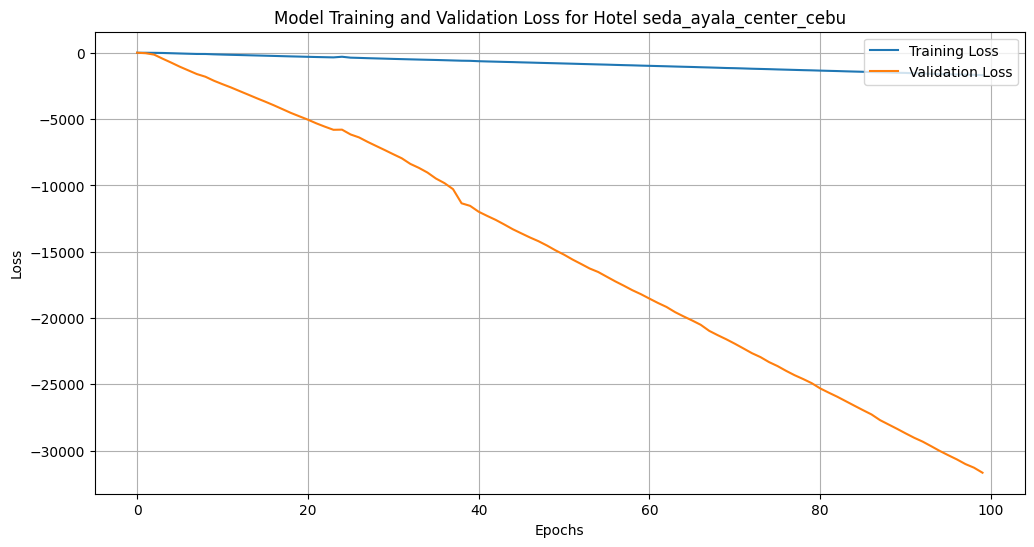

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8088 - loss: 419.7654
Test Loss for Hotel seda_ayala_center_cebu: 271.83612060546875
Test Accuracy for Hotel seda_ayala_center_cebu: 0.808849573135376
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Classification Report for Hotel seda_ayala_center_cebu:
              precision    recall  f1-score   support

    Negative       0.48      0.32      0.38        97
    Positive       0.87      0.93      0.90       468

    accuracy                           0.82       565
   macro avg       0.67      0.62      0.64       565
weighted avg       0.80      0.82      0.81       565



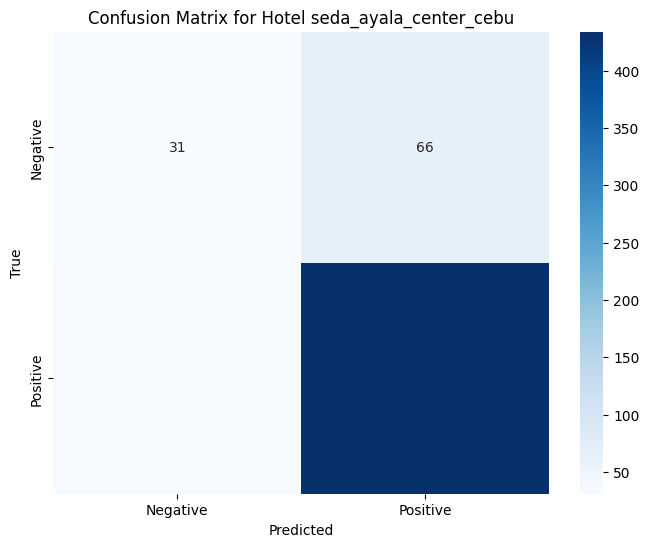

Mean Squared Error for Hotel seda_ayala_center_cebu: 0.2336229949665468
Predicted sentiment values for Hotel seda_ayala_center_cebu saved in ../predictions/5_seda_ayala_center_cebu



Training the CNN-biLSTM model for Hotel waterfront_hotel_and_casino...


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.3982 - loss: 0.5807 - val_accuracy: 0.0000e+00 - val_loss: -1.8121
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6264 - loss: -3.0367 - val_accuracy: 0.0000e+00 - val_loss: -20.0883
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5969 - loss: -27.1899 - val_accuracy: 0.0000e+00 - val_loss: -312.7210
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6022 - loss: -63.7869 - val_accuracy: 0.0000e+00 - val_loss: -831.2174
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6778 - loss: -123.9459 - val_accuracy: 0.0000e+00 - val_loss: -1274.4371
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7082 - loss: -198.7183 - val_accuracy: 0.0000e+00 - val_loss: -1890.8779
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7533 - loss: -263.2308 - val_accuracy: 0.0000e+00 - val_loss: -2358.5701
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s

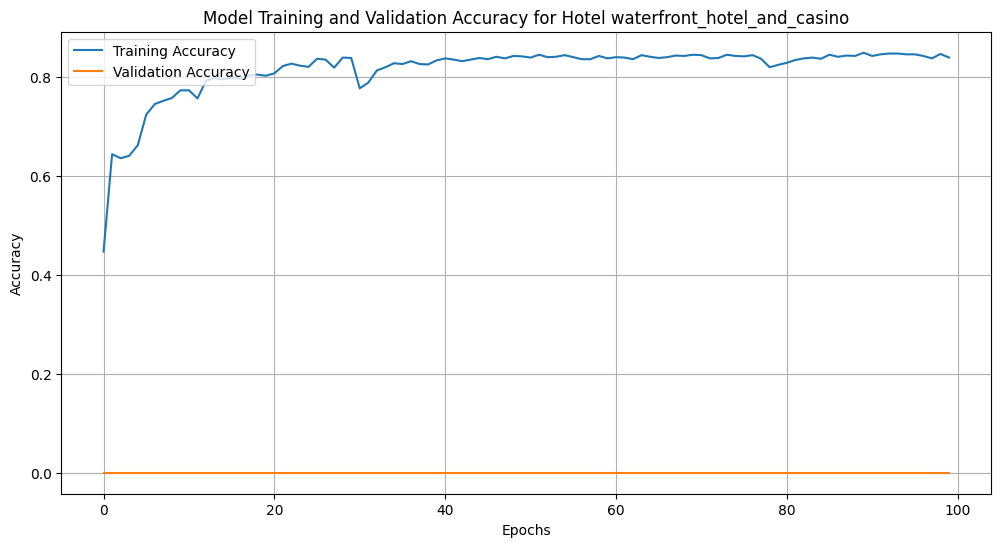

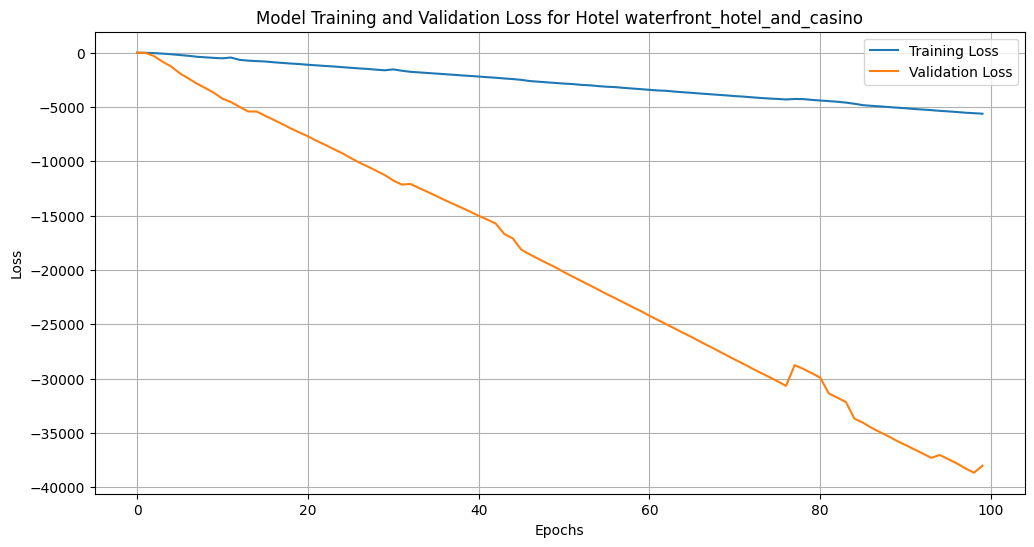

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6816 - loss: 551.3923
Test Loss for Hotel waterfront_hotel_and_casino: 302.3986511230469
Test Accuracy for Hotel waterfront_hotel_and_casino: 0.6701902747154236
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step

Classification Report for Hotel waterfront_hotel_and_casino:
              precision    recall  f1-score   support

    Negative       0.61      0.66      0.63       163
    Positive       0.81      0.78      0.79       310

    accuracy                           0.74       473
   macro avg       0.71      0.72      0.71       473
weighted avg       0.74      0.74      0.74       473



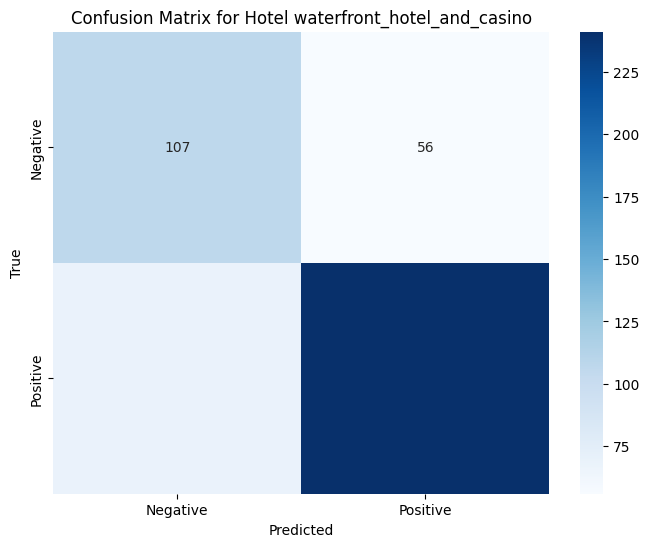

Mean Squared Error for Hotel waterfront_hotel_and_casino: 0.3805968839947487
Predicted sentiment values for Hotel waterfront_hotel_and_casino saved in ../predictions/6_waterfront_hotel_and_casino


In [8]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 100

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Load preprocessed data for a single hotel
def load_data(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../augmented_datasets/{folder_name}/{hotel_name}_augmented_reviews.npz"
        data = np.load(data_path)
        return data
    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None

# Train and evaluate the model for a single hotel
def train_and_evaluate_model(x_train, x_test, y_train, y_test, label):
    try:
        input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
        conv1d = Conv1D(128, 5, activation='relu')(embedding)
        maxpool = MaxPooling1D(2)(conv1d)
        bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
        dropout = Dropout(0.5)(bi_lstm)
        flat = Flatten()(dropout)
        output = Dense(1, activation='sigmoid')(flat)
        model = Model(inputs=input_text, outputs=output)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"\n\n\nTraining the CNN-biLSTM model for {label}...")
        
        # Calculate class weights
        class_weights = {0: len(y_train) / (2 * np.bincount(y_train == 0)[0]), 
                        1: len(y_train) / (2 * np.bincount(y_train == 1)[1])}

        # Train the model with class weights
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, class_weight=class_weights)

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Training and Validation Accuracy for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training and Validation Loss for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss for {label}: {loss}")
        print(f"Test Accuracy for {label}: {accuracy}")

        y_pred_prob = model.predict(x_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Ensure y_test is binary for classification report
        y_test_binary = (y_test > 0.5).astype(int)

        print(f"\nClassification Report for {label}:")
        print(classification_report(y_test_binary, y_pred, target_names=['Negative', 'Positive']))

        conf_matrix = confusion_matrix(y_test_binary, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        # Evaluate regression metrics for continuous predictions
        mse = mean_squared_error(y_test, y_pred_prob)
        print(f"Mean Squared Error for {label}: {mse}")

        # Save and print the predicted sentiment values
        output_folder = f"../predictions/{hotel_folder_mapping[label.split()[1]]}"
        os.makedirs(output_folder, exist_ok=True)
        np.savez_compressed(os.path.join(output_folder, f"{label}_predictions.npz"), y_pred_prob=y_pred_prob)
        print(f"Predicted sentiment values for {label} saved in {output_folder}")

    except Exception as e:
        print(f"Error during training and evaluation for {label}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Perform sentiment analysis for each hotel
for hotel in hotels:
    data = load_data(hotel)
    if data is not None:
        x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
        train_and_evaluate_model(x_train, x_test, y_train, y_test, f'Hotel {hotel}')
    else:
        print(f"Skipping sentiment analysis for {hotel} due to data loading error.")

        
###! GENERAL ANALYSIS OF RESULTS: 
# ! 1. potential overfitting : the imbalance is likely causing the model to be biased towards predicting the positive class
# ! 2. the model correctly identifies the positive samples almost all the time but struggles significantly with the negative samples
# ! 3. class imbalance is a significant issue in the dataset, and the model is not able to generalize well to the negative class

###* Addressing Class Imbalance
# * 1. oversampling the minority class (negative reviews) using techniques like SMOTE
# * 2. undersampling the majority class (positive reviews)
# * 3. using class weights during training to penalize misclassifications in the minority class
# * 4. using a different evaluation metric like F1-score or AUC-ROC that is less sensitive to class imbalance

# CONCLUSION: original general sentiment analysis produced better results which seemed to learn more than sa augmented training set

## Loading of predicted values

In [9]:
import numpy as np
import os

# List of hotels and their respective folders
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and print predicted values
def load_and_print_predictions(hotel_name):
    folder_name = hotel_folder_mapping[hotel_name]
    prediction_path = f"../predictions/{folder_name}/Hotel {hotel_name}_predictions.npz"
    
    try:
        data = np.load(prediction_path)
        y_pred_prob = data['y_pred_prob']
        print(f"Predicted sentiment values for {hotel_name}:\n{y_pred_prob}")
    except Exception as e:
        print(f"Error loading predictions for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Load and print predictions for each hotel
for hotel in hotels:
    load_and_print_predictions(hotel)
    
#* NOTE: these are the predicted sentiment value of EACH review

Predicted sentiment values for bai_hotel:
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Predicted sentiment values for dusit_thani_mactan:
[[0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [6.8682480e-14]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00

# Aspect-based Sentiment Analysis

In [10]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RangeIndex(start=0, stop=0, step=1)


KeyError: 'Labels'

## KDE for each hotel

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

NameError: name 'model' is not defined

In [ ]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 1.8867376e-11, 'Comfort & Facilities': 29.187944, 'Food': 35.120018, 'Internet': 0.0, 'Location': 5.216267, 'Staff': 30.139652, 'Value for money': 0.33602843}


,Aspect,Percentage Likelihood
3,Food,3.512002e+01
6,Staff,3.013965e+01
2,Comfort & Facilities,2.918794e+01
5,Location,5.216267e+00
7,Value for money,3.360284e-01
1,Cleanliness,1.886738e-11
0,,0.000000e+00
4,Internet,0.000000e+00
